<h1> House Prices: Advanced Regression Techniques</h1>

This is my attempt at the House Prices competition on www.Kaggle.com. The goal of this competition is to create a model which takes in numerical and categorical data about houses and predicts the price the house will sell for. The metric we aim to minimize is the RMSLE (Root-Mean-Squared-Log-Error) between the predicted and actual price the home sold for. 

To do this we will need to:
- Explore the data
- Clean the data
- Rescale and engineer some of the numerical features
- Train ML models on the data

Let's begin with a few common imports and setting up the iPython Environment

In [1]:
%matplotlib inline

import numpy as np  
import pandas as pd 
import matplotlib as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import sklearn

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

print('Module \t\t|','Version')
print('--'*13)
print('numpy \t\t|',np.__version__)
print('matplotlib \t|',pl.__version__)
print('seaborn \t|',sns.__version__)
print('pandas \t\t|',pd.__version__)
print('sklearn \t|',sklearn.__version__)

Module 		| Version
--------------------------
numpy 		| 1.13.3
matplotlib 	| 2.1.0
seaborn 	| 0.8.0
pandas 		| 0.20.3
sklearn 	| 0.19.1


<h2>Explore the Data</h2>

Let us first import the training and testing datasets into pandas dataframes

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We will now explore the types of data we are working with. We can acomplish this by accessing the DataFrame attribute dtypes which returns the data type for each attibute.

In [4]:
train.dtypes.value_counts().to_frame(name = 'counts')

,counts
object,43
int64,35
float64,3


We see that we have: 
- 43 categorical attributes
- 38 numerical attributes of which 35 are integer type data and 3 are floating point numbers

For later convenience we will store the names of the attibutues into two separte lists for the numerical and categorical type data

In [5]:
cat_col = train.select_dtypes(include = ['object']).columns        # cat_col : short for categorical columns
num_col = train.select_dtypes(exclude = ['object']).columns[0:-1]  # num_col : short for numerical columns

Next we will explore the percentage of missing data for each attribute. We will plot this data to quickly visualize how much data is missing from each attribute. To assist with this we will make a simple helper functions to generate a pandas series with the features and percentage of missing data.


In [6]:
def null_data_pcnt(df):
    '''
    input: data frame
    output: returns perentage of null values for each column with null values
    '''
    null_df = df.isnull().sum()/df.shape[0]*100
    null_df = null_df[null_df > 0].sort_values(ascending = False)
    return null_df

In [7]:
null_data_pcnt(train).to_frame(name = '% missing')

,% missing
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageYrBlt,5.55
GarageType,5.55
GarageFinish,5.55
GarageQual,5.55


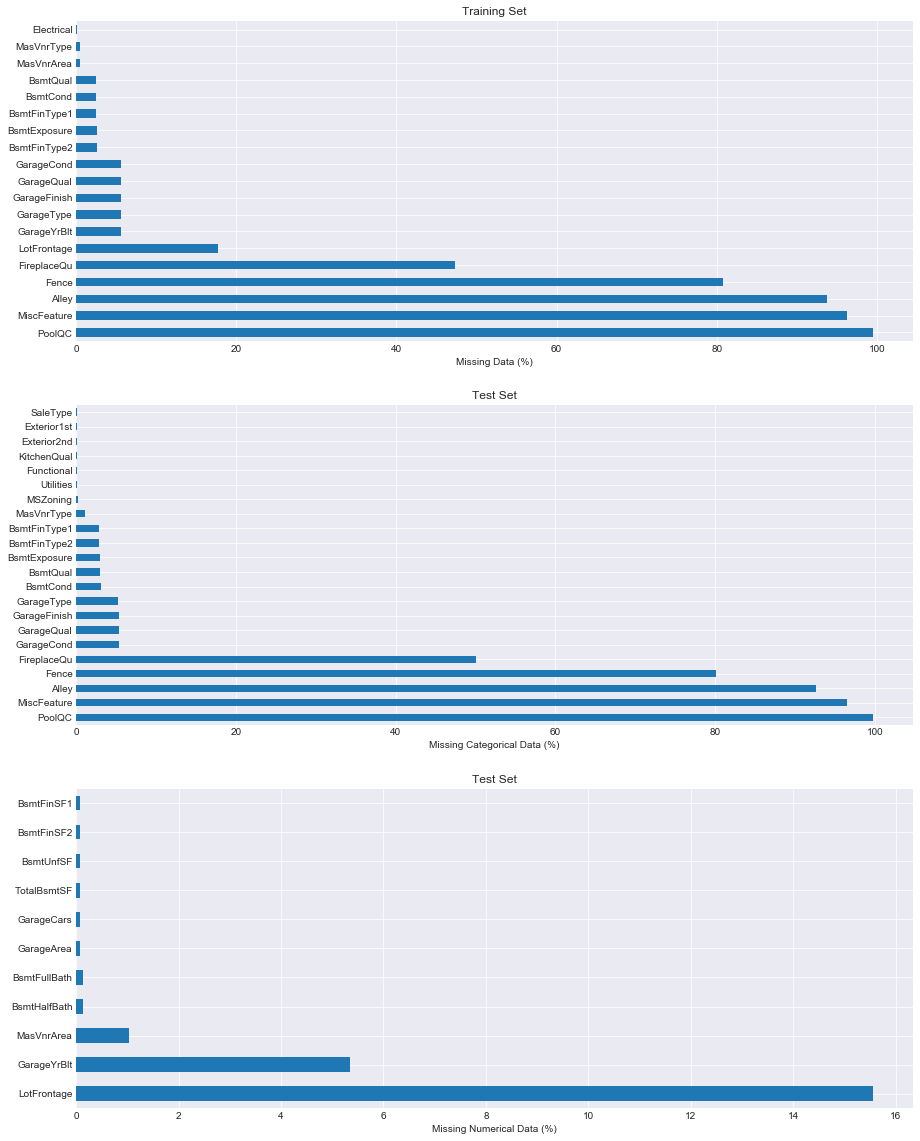

In [30]:
plt.figure(figsize= (20,30))

plt.subplot(3,1,1)
null_data_pcnt(train).plot.barh(grid = True, figsize = (15,10))
plt.title('Training Set')
plt.xlabel('Missing Data (%)')

plt.subplot(3,1,2)
null_data_pcnt(test.select_dtypes(include = ['object'])).plot.barh(grid = True, figsize = (15,20))
plt.title('Test Set')
plt.xlabel('Missing Categorical Data (%)')

plt.subplot(3,1,3)
null_data_pcnt(test.select_dtypes(exclude = ['object'])).plot.barh(grid = True, figsize = (15,20))
plt.title('Test Set')
plt.xlabel('Missing Numerical Data (%)')

plt.show()

It can be useful to examine how various features are correlated with one another and how they are correlated with the target variable, which in our case is the SalePrice.

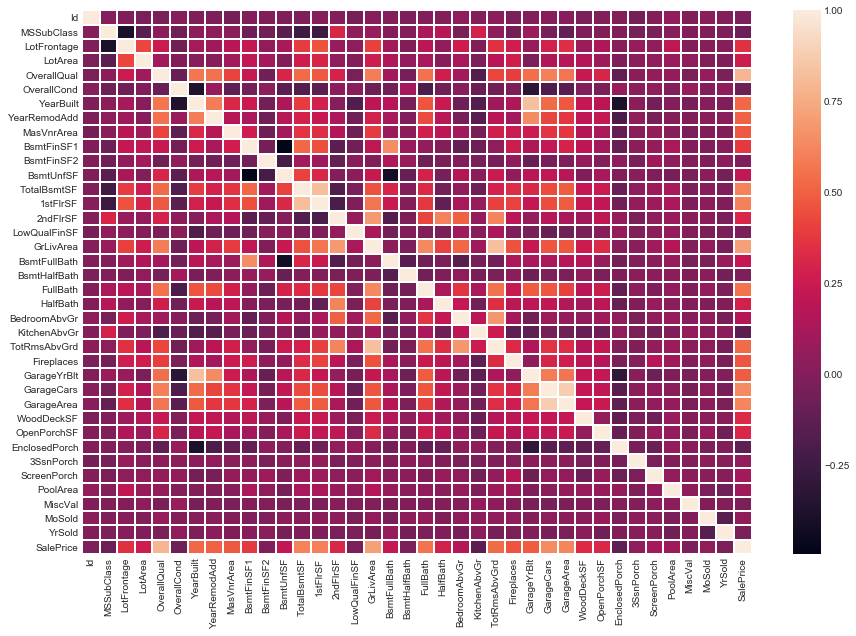

In [9]:
fig, ax = plt.subplots(figsize = (15,10))

corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           linewidths = 1,
           annot = False)
fig.show()

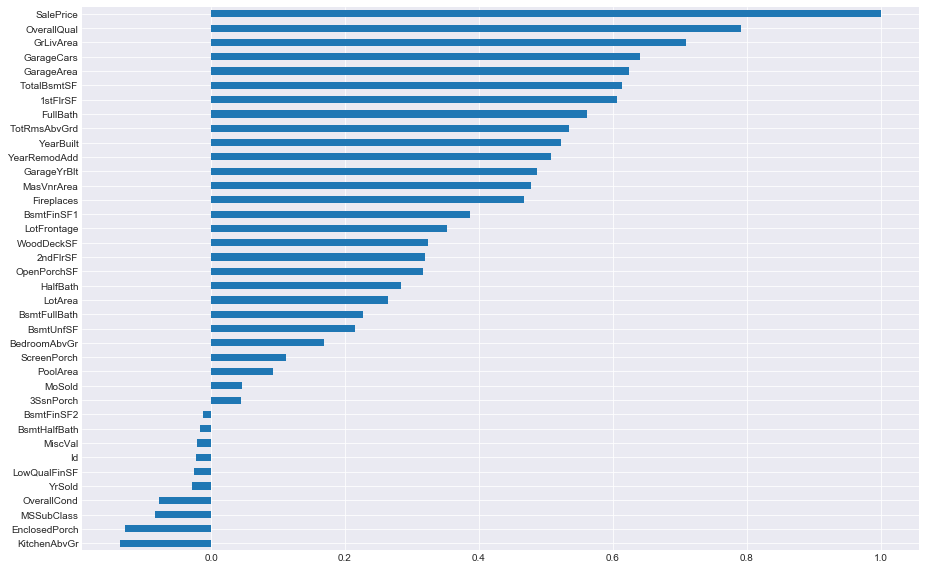

In [10]:
train.corr()['SalePrice'].sort_values(ascending = True).plot.barh(figsize = (15,10))

Looking at the correlations between variables is a great start but this can be limiting. Plotting the features against the target may give us additional information. Below we will plot the 

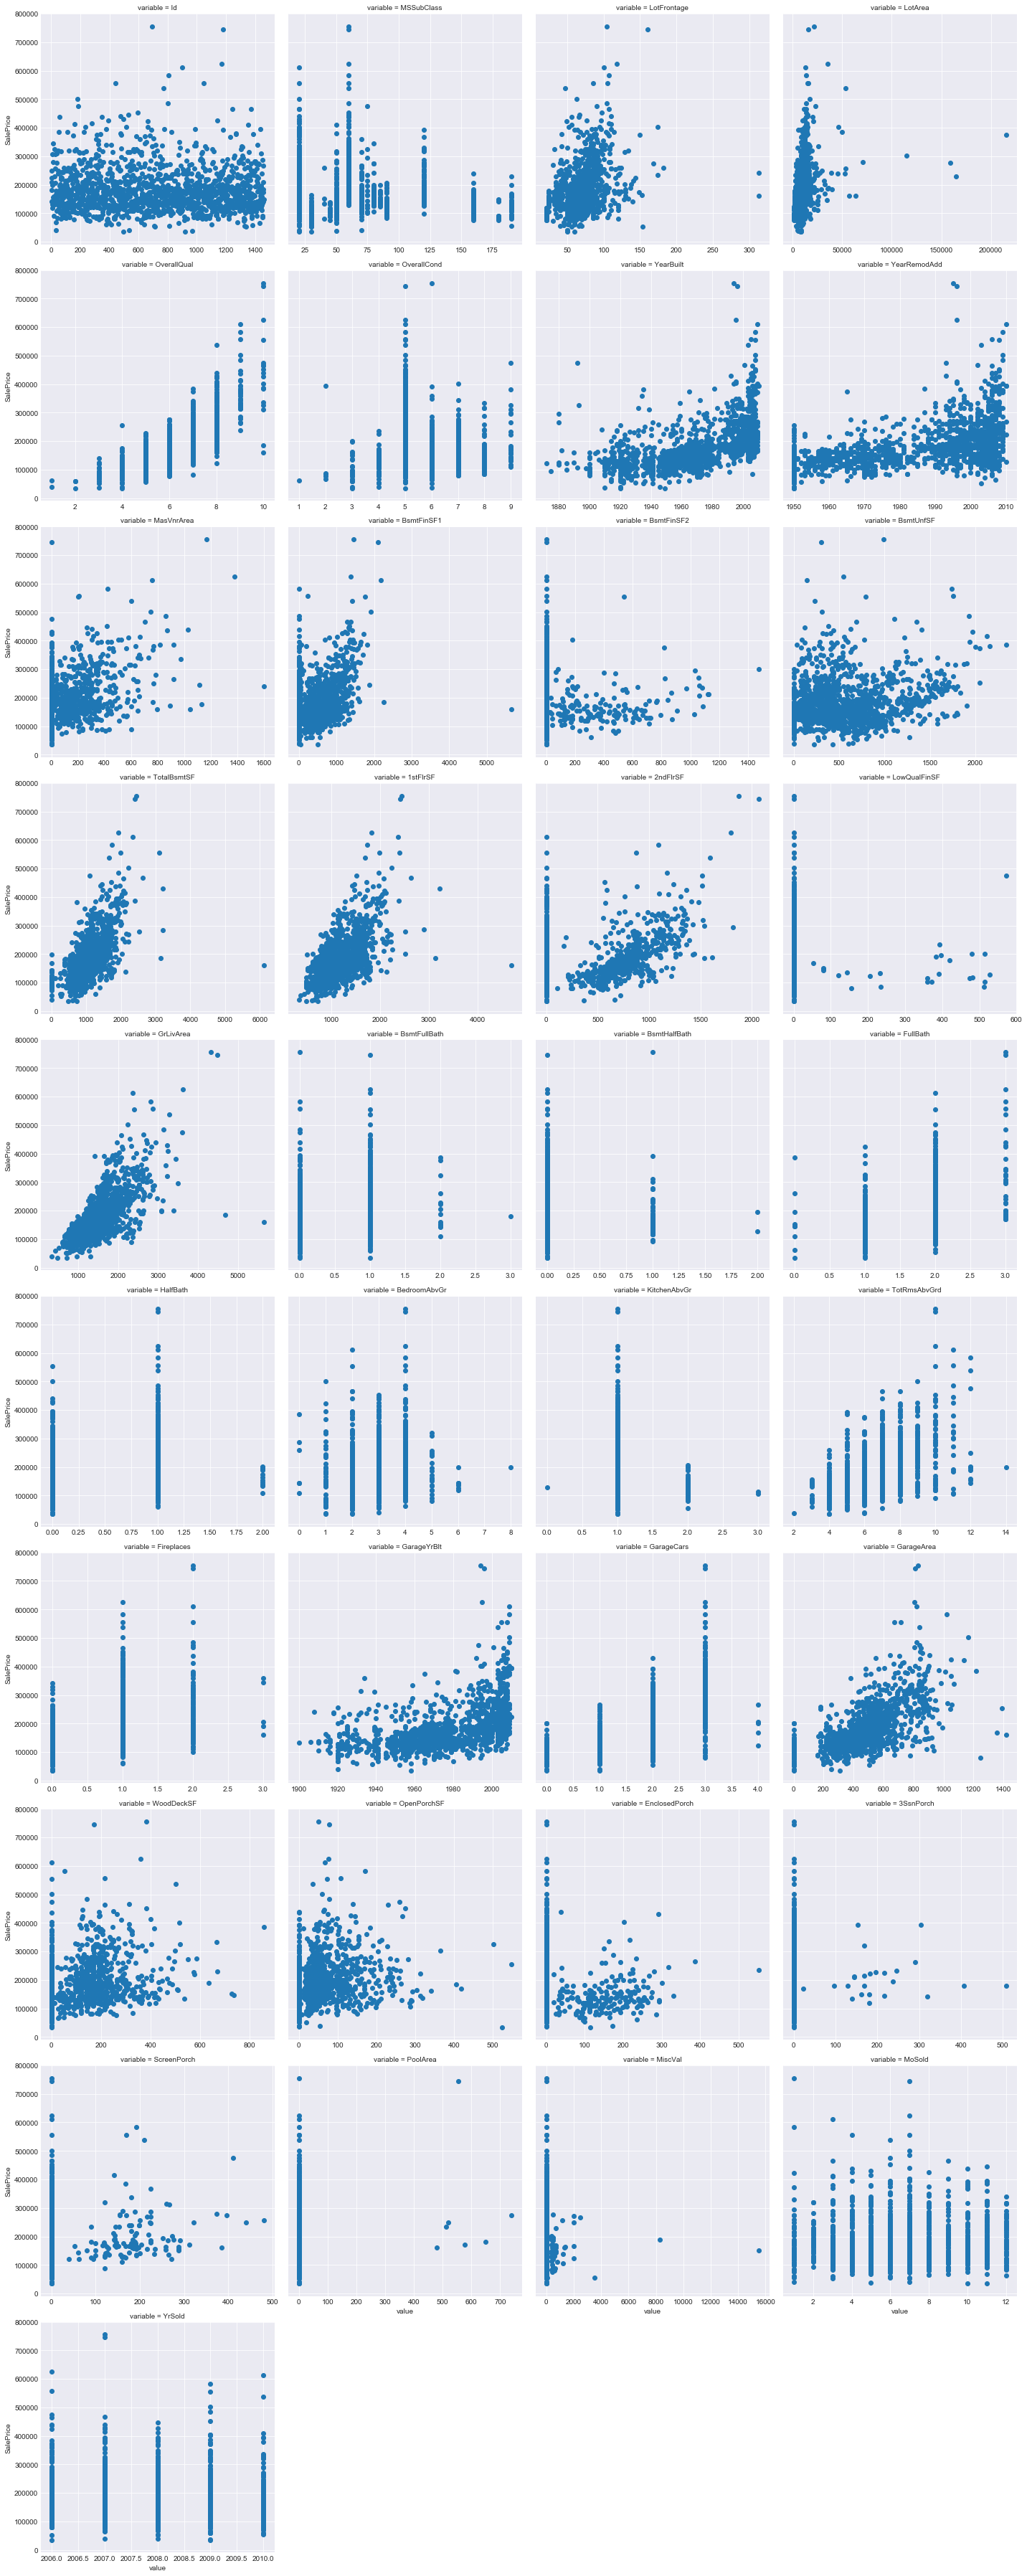

In [11]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars= num_col)

g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False,  size=5)
g = g.map(plt.scatter, "value", "SalePrice")



Taking a closer look at the MSSubClass, MoSold, YrSold features indicate that these are perhaps more categorical in nature. For example a particular Month may be more of a buyer's or seller's market which has an impact on the SalePrice, and there appears to be no particular ordering of the MSSubClass label and the average SalePrice. I'll recast these features as object type data later.

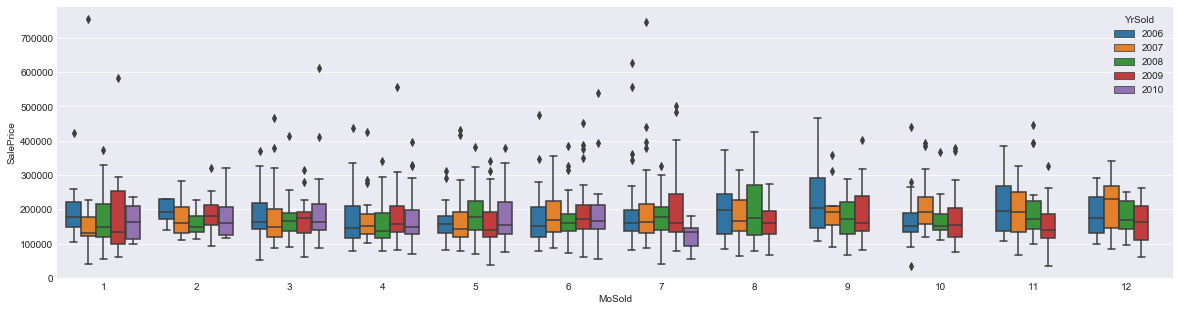

In [20]:
fig, ax = plt.subplots(figsize = (20,5))

sns.boxplot(x = 'MoSold', y = 'SalePrice', hue= 'YrSold', data = train, ax = ax)
fig.show()

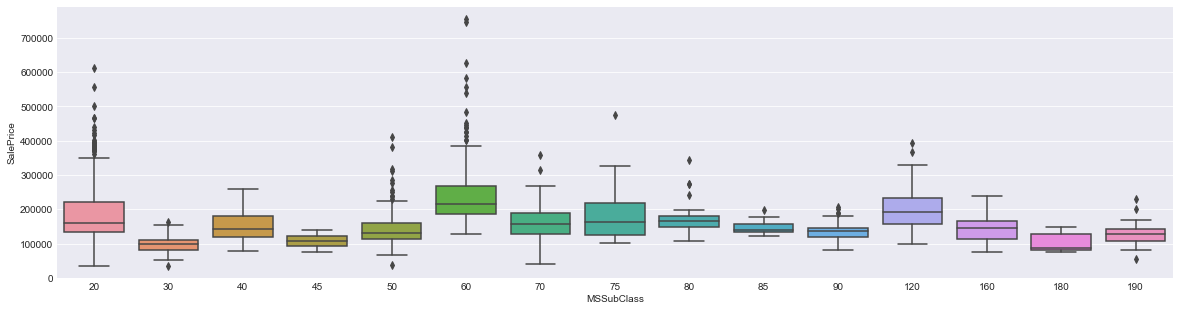

In [21]:
fig, ax = plt.subplots(figsize = (20,5))

sns.boxplot(x = 'MSSubClass', y = 'SalePrice', data = train, ax = ax)

fig.show()

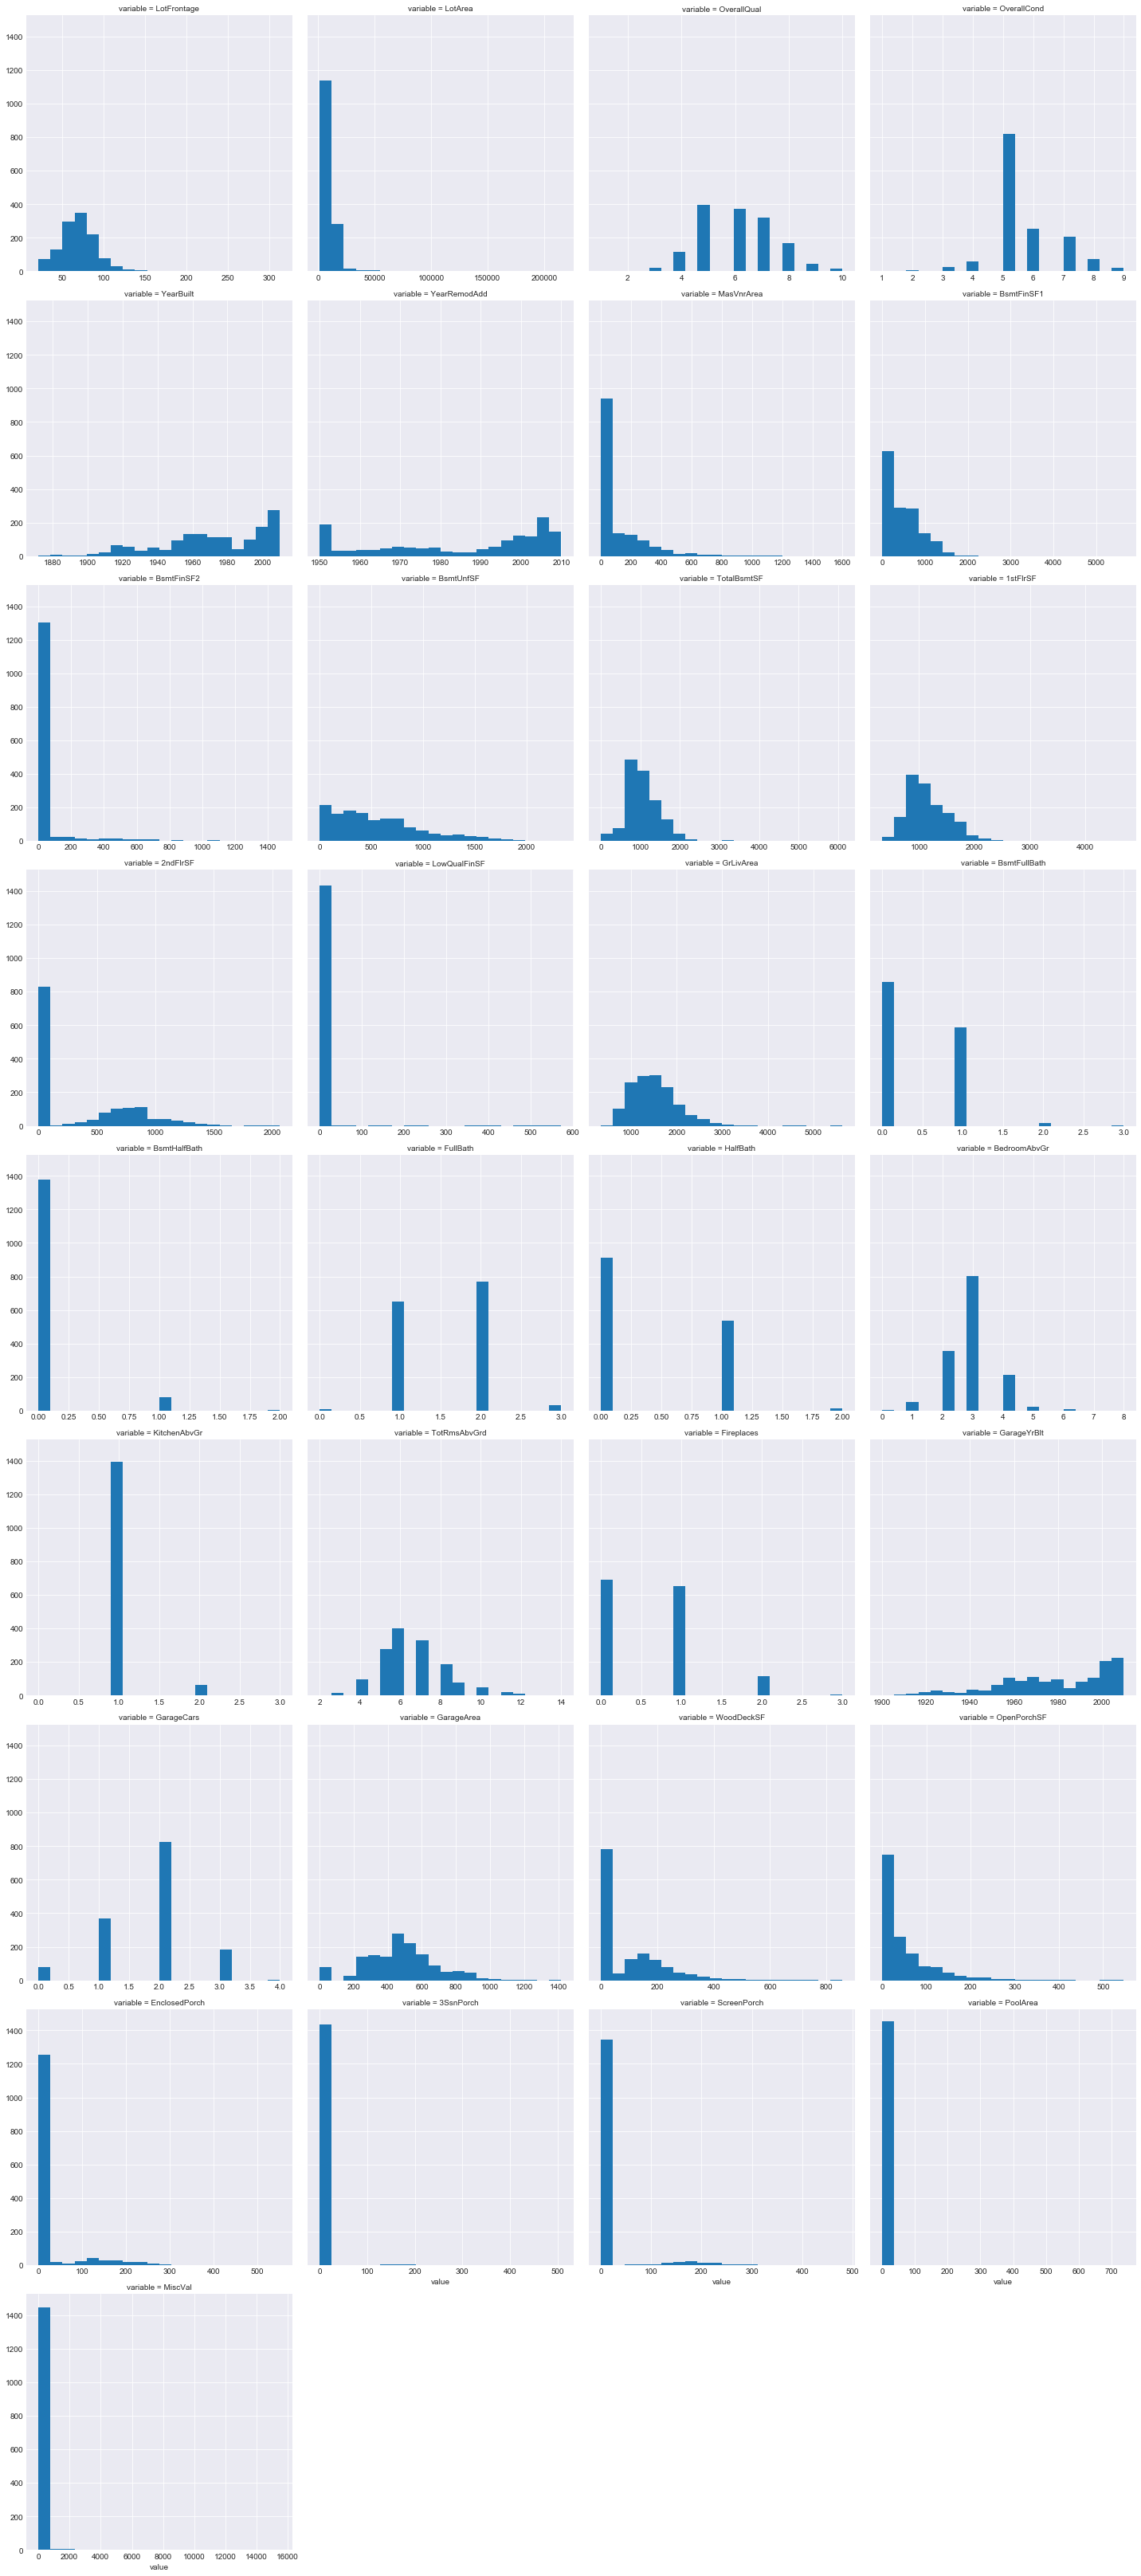

In [11]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars= num_col[2:-2])
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, size=5)

g = g.map(plt.hist, 'value' , bins = 20)

Some of the data above appears highly skewed. Our linear models will perform better if we transform them so that they are closer to being normally distributed. We will address this later

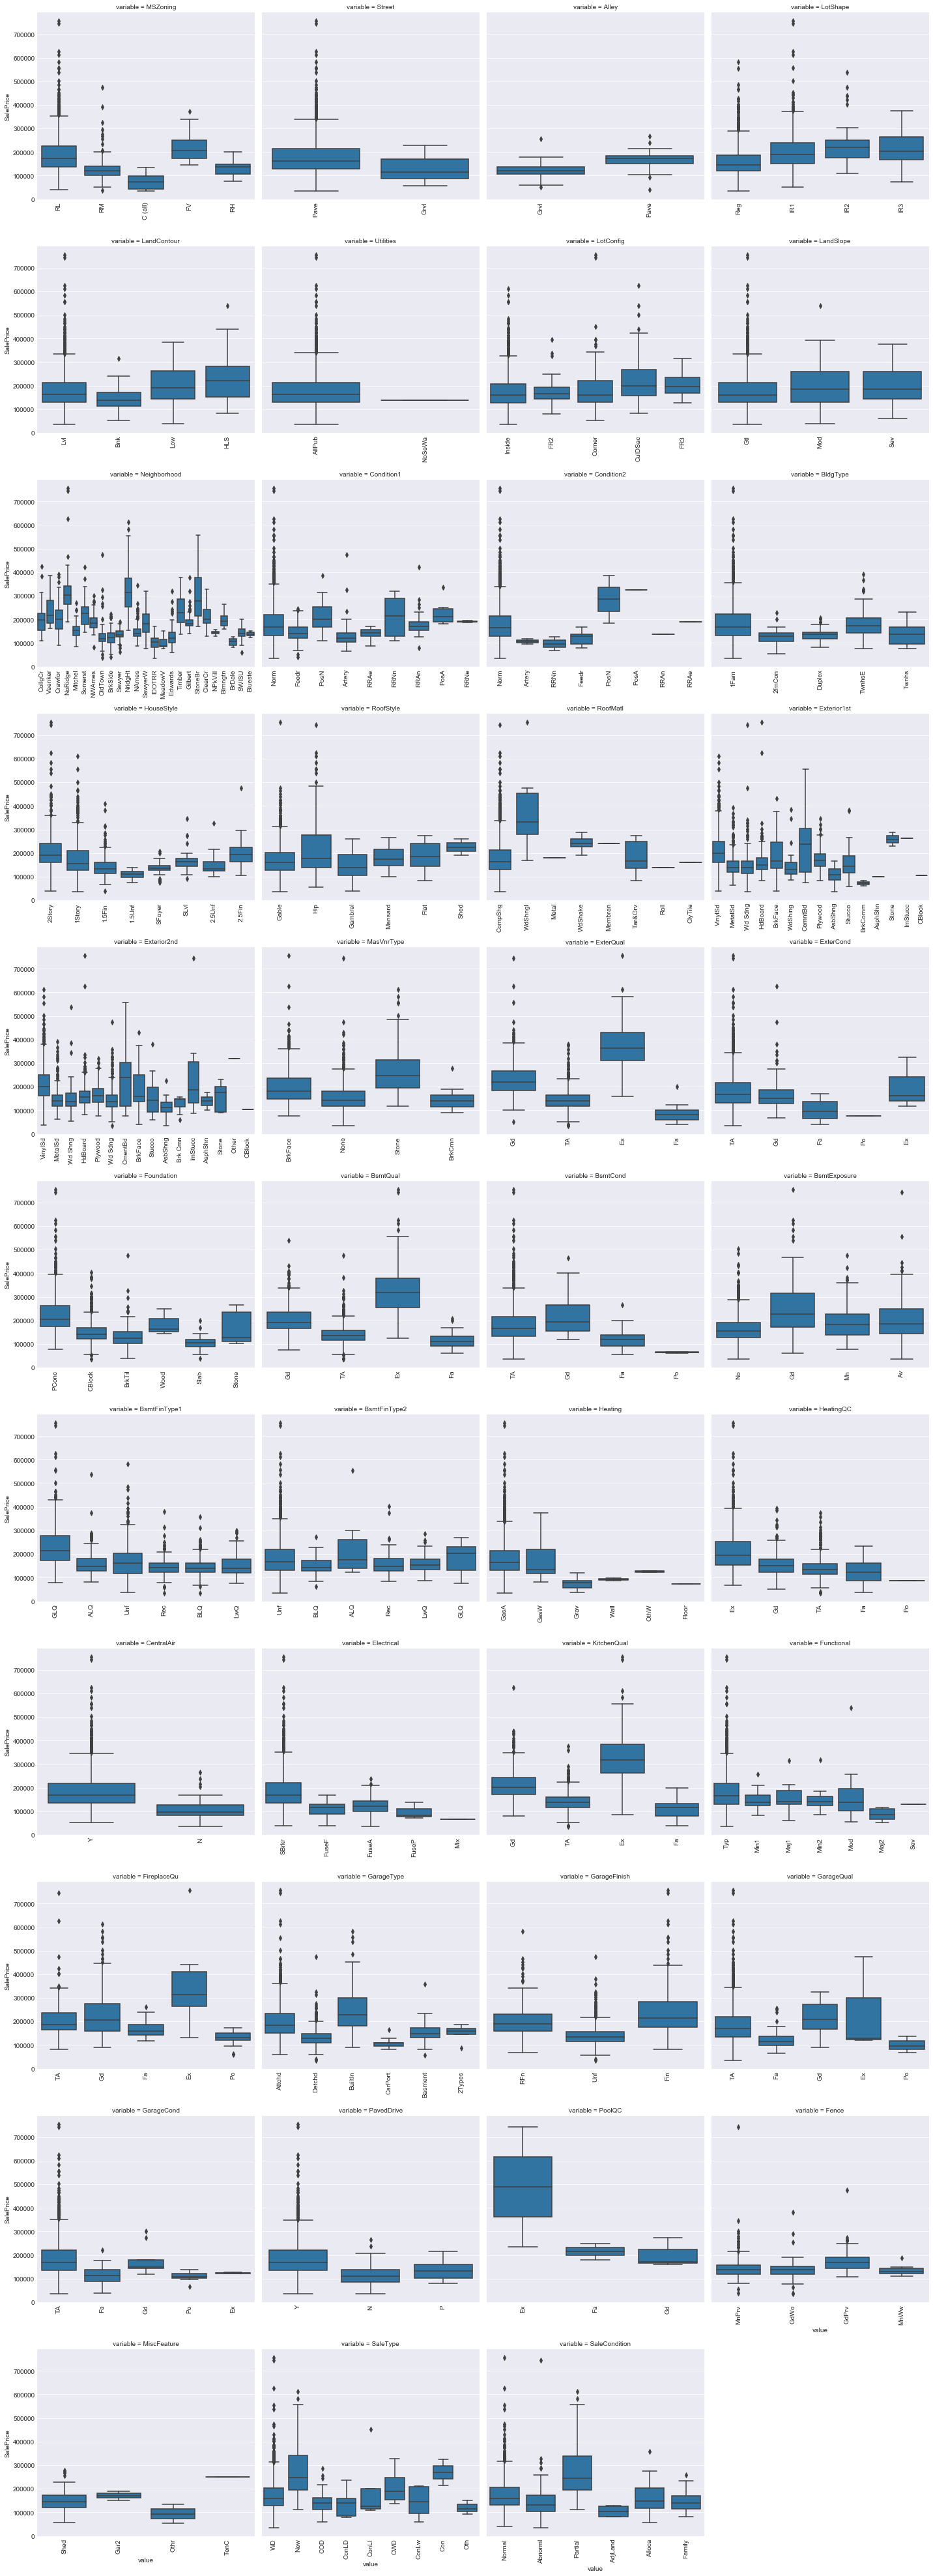

In [12]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars= cat_col)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, size=5)

g = g.map(sns.boxplot , 'value' , 'SalePrice')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

g.fig.tight_layout()
        
plt.show()


One thing to note in the last sets of plots is that in the Utilities vs SalePrice plot all but one of the utilities is of type AllPub. This indicates that Utilities is not an important feature that we want our model to be trained on and should probably remove it. We will take care of this later.

<h2>Prepare the Data</h2>
Before altering the data we will create copies of the data so that we leave the original data intact 
 

In [15]:
train_cp = train.copy()
test_cp = test.copy()

<h3>Outliers</h3>
One plot that indicates some atypical data is the scatter plot of the SalePrice vs GrLivArea. There are two points with large sq. footage but relatively small SalePrice deviating from the linear trend. I will make the choice to remove them from the training set.



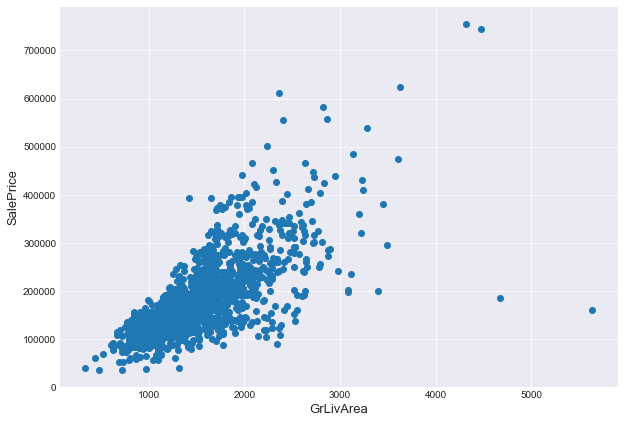

In [16]:
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(x = train_cp['GrLivArea'], y = train_cp['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [17]:
train_cp = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

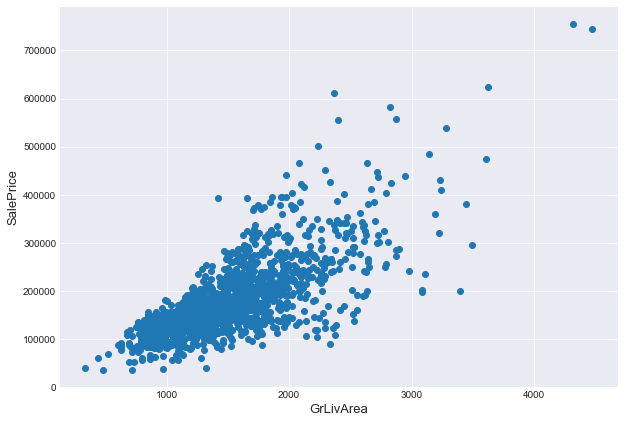

In [19]:
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(x = train_cp['GrLivArea'], y = train_cp['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#### Unuseful Data

The boxplots of SalePrice vs Utilities reavealed that all but one sale was associated with a single class. It is therfore reasonable to assume that this is an unimportant feature for determining the SalePrice so we will discard it. 

In [20]:
train_cp.drop(labels= 'Utilities', axis = 1, inplace = True)
test_cp.drop(labels= 'Utilities', axis = 1, inplace = True)

In [21]:
train_count = train_cp.shape[0]
test_count = test_cp.shape[0]

y_train = train_cp.SalePrice.values

all_data = pd.concat((train_cp, test_cp)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [22]:
cat_col = all_data.select_dtypes(include = ['object']).columns
num_col = all_data.select_dtypes(exclude = ['object']).columns

In [23]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.00,0.00,...,Normal,WD,0,Pave,8,856.00,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.00,0.00,...,Normal,WD,0,Pave,6,1262.00,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.00,0.00,...,Normal,WD,0,Pave,6,920.00,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.00,0.00,...,Abnorml,WD,0,Pave,7,756.00,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.00,0.00,...,Normal,WD,0,Pave,9,1145.00,192,2000,2000,2008


In [24]:
def null_cols(df):
    return df.isnull().sum()[ df.isnull().sum().values >0 ]

In [25]:
null_cols(all_data[cat_col]).to_frame(name = '# of missing entries')

,# of missing entries
Alley,2719
BsmtCond,82
BsmtExposure,82
BsmtFinType1,79
BsmtFinType2,80
BsmtQual,81
Electrical,1
Exterior1st,1
Exterior2nd,1
Fence,2346


In [26]:
#
#   Most of the null values actually mean none and not unknown. should refill with that
#   most data should be imputed with mode of the neighborhood
#
na_none = ['MasVnrType','Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [27]:
all_data[na_none] = all_data[na_none].fillna(value = 'none')

#   The documentation says that if Functional is Null then
#   it should be assumed to be Typical and filled with Typ

all_data['Functional'].fillna(value = 'Typ', inplace = True)

In [28]:
null_cols(all_data[cat_col]).to_frame(name = '# of missing entries')

,# of missing entries
Electrical,1
Exterior1st,1
Exterior2nd,1
KitchenQual,1
MSZoning,4
SaleType,1


In [29]:
all_data[null_cols(all_data[cat_col]).axes[0]].head(train_count).mode()

,Electrical,Exterior1st,Exterior2nd,KitchenQual,MSZoning,SaleType
0,SBrkr,VinylSd,VinylSd,TA,RL,WD


In [30]:
for i in null_cols(all_data[cat_col]).axes[0]:
    val = all_data[null_cols(all_data[cat_col]).axes[0]].head(train_count).mode()[i].values[0]
    all_data[i].fillna(value = val, inplace = True)

In [31]:
null_cols(all_data[cat_col]).to_frame(name = '# of missing entries')

,# of missing entries


In [32]:
null_cols(all_data[num_col]).to_frame(name = '# of missing entries')

,# of missing entries
BsmtFinSF1,1
BsmtFinSF2,1
BsmtFullBath,2
BsmtHalfBath,2
BsmtUnfSF,1
GarageArea,1
GarageCars,1
LotFrontage,486
MasVnrArea,23
TotalBsmtSF,1


Takin a look at the average LotFrontage for each Neighborhood indicates that it may be advantages to impute LotFrontage with the averarage LotFrongate for the Neighborhood it is located in, instead of the average LotFrontage of all the houses in the training set. We will take this path.

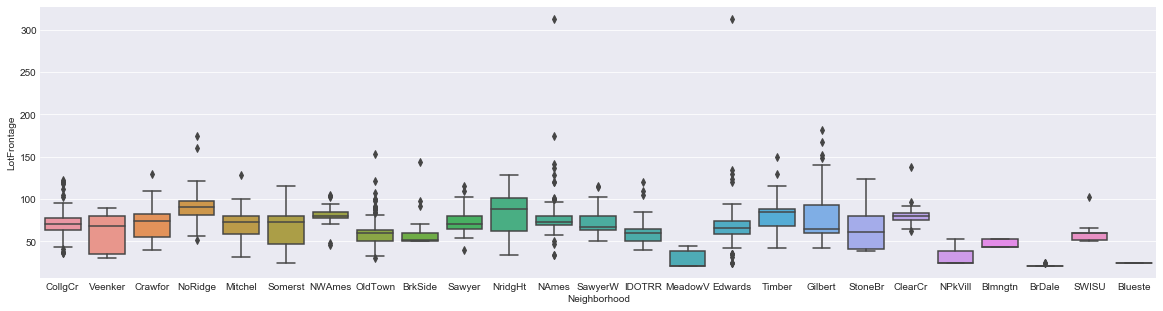

In [29]:
fig, ax = plt.subplots(figsize = (20,5))

sns.boxplot(x = 'Neighborhood', y = 'LotFrontage', data = train, ax=ax)

fig.show()

In [33]:

# impute lotfrontage based off neighborhood averages 
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#  The rest of the features we will impute with zeros which assumes
#  that the home does not have that feature
for i in ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']:
    all_data[i].fillna(0, inplace = True)
    
null_cols(all_data[num_col]).to_frame(name = '# of missing entries')

,# of missing entries


In [34]:
# recasting YrSold, MoSold, and MSSubClass to object datatypes
all_data['YrSold'] = all_data['YrSold'].astype(object)
all_data['MoSold'] = all_data['MoSold'].astype(object)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(object)

In [35]:
all_data_cp = all_data.copy()

# Creating two new features:
#     AvgRoomSize which takes Above ground living area and dive it by the number of above ground rooms
#     TotLivingArea which is the sum of the above ground living area and the basement squre footage
all_data_cp['AvgRoomSize'] =  all_data['GrLivArea'] / all_data['TotRmsAbvGrd']
all_data_cp['TotLivingArea'] =  all_data['GrLivArea'] + all_data['TotalBsmtSF']

test_ID = all_data_cp[train_count:]['Id']

all_data_cp.drop(labels= 'Id', axis = 1, inplace = True)

new_cat_cols = all_data_cp.select_dtypes(include = ['object']).columns
new_num_cols = all_data_cp.select_dtypes(exclude = ['object']).columns

Below we explore the distibution of the numerical data and examine how skewed the distributions are. We then apply a box cox transformation to features that exhibit largely skewed data.

In [36]:
from scipy import stats
from scipy.stats import skew

In [37]:
skewed_feats = all_data_cp[new_num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

,Skew
MiscVal,21.94
PoolArea,17.69
LotArea,13.11
LowQualFinSF,12.08
3SsnPorch,11.37
KitchenAbvGr,4.30
BsmtFinSF2,4.14
EnclosedPorch,4.00
ScreenPorch,3.95
BsmtHalfBath,3.93


In [38]:
skewness = skewness[abs(skewness) > 0.8].dropna(axis = 0)
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam =  0.25

for feat in skewed_features:
    all_data_cp[feat] = boxcox1p(all_data_cp[feat], lam)

There are 21 skewed numerical features to Box Cox transform


In [43]:
skewed_feats2 = all_data_cp[new_num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\t Skew in numerical features:\n -------------------------------------------")
skewness2 = pd.DataFrame({'Skew' :skewed_feats2})
skewness2.head(25)

	 Skew in numerical features:
 -------------------------------------------


,Skew
PoolArea,15.89
3SsnPorch,9.02
LowQualFinSF,8.92
MiscVal,6.17
KitchenAbvGr,3.80
BsmtHalfBath,3.80
ScreenPorch,3.01
BsmtFinSF2,2.66
EnclosedPorch,2.09
LotArea,0.78


In [44]:
all_data_cp = pd.get_dummies(all_data_cp)
print(all_data_cp.shape)

(2917, 435)


In [45]:
all_data_cp.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,17.64,17.63,0.00,3,16.63,0.00,1.00,0.00,10.02,0.00,...,0,0,1,0,1,0,0,1,0,0
1,19.85,0.00,0.00,3,18.37,0.00,0.00,0.76,12.44,0.00,...,0,0,1,0,1,0,1,0,0,0
2,18.04,17.71,0.00,3,14.79,0.00,1.00,0.00,14.27,0.00,...,0,0,1,0,1,0,0,1,0,0
3,18.28,16.98,0.00,3,11.35,0.00,1.00,0.00,15.29,12.26,...,0,0,1,0,1,1,0,0,0,0
4,19.27,18.79,0.00,4,16.24,0.00,1.00,0.00,14.83,0.00,...,0,0,1,0,1,0,0,1,0,0


In [46]:
train_prep = all_data_cp[:train_count]
y_train_log = np.log(y_train)
test_prep = all_data_cp[train_count:]

<h2><center>Train Models on Data</center></h2>

In [47]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [48]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_prep.values)
    
    rmse= np.sqrt(-cross_val_score(model, 
                                   train_prep.values, 
                                   y_train_log, 
                                   scoring='neg_mean_squared_error', 
                                   cv = kf))
    return(rmse)

In [50]:
# Hyperparameters for lasso, ridge, and ENet were chosen with GridSearch CV
# in separate iteration of this notebook. I use RandomizedSearchCV from scikit-learn
# to choose hyperparameters for GBoost since there are a greater number more parameters to tune

lasso = make_pipeline( RobustScaler() , Lasso(alpha =5e-4, max_iter = 1000))

ridge = make_pipeline( RobustScaler() , Ridge(alpha =24.0, max_iter = 1000))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = .0005, l1_ratio = .9, max_iter = 1000))

GBoost = GradientBoostingRegressor(n_estimators = 1000,
                                   max_features='sqrt', 
                                   loss='huber', 
                                   random_state =5)

In [63]:
from time import time
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [2,3,4,5],
              "learning_rate" : [.01,.025,.05,.075,.1],
              "alpha": [.85 + x*.01 for x in range(0,11)],
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 20)}

In [64]:
n_iter_search = 200

random_search = RandomizedSearchCV(GBoost, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, 
                                   verbose= 1,
                                   cv = 5, 
                                   scoring="neg_mean_squared_error",
                                   n_jobs = -1)

In [65]:
random_search.fit(train_prep, y_train_log);

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 16.2min finished


In [66]:
random_search.best_params_

{'alpha': 0.85,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_leaf': 6,
 'min_samples_split': 17}

In [67]:
GBoost = GradientBoostingRegressor(alpha = 0.85,
                                   learning_rate=0.1,
                                   max_depth= 2,
                                   min_samples_leaf=6, 
                                   min_samples_split=17,
                                   n_estimators=1000,
                                   max_features='sqrt',
                                   loss='huber', 
                                   random_state =5)


In [68]:
rmsle_cv(GBoost).mean()

0.11269048862693989

In [69]:
for i,j in {'lasso': lasso, 'ridge': ridge, 'ENet': ENet, 'GBoost': GBoost}.items():
    score = rmsle_cv(j)
    print("{:s} score: {:.4f} ({:.4f})\n".format(i, score.mean(), score.std()))



lasso score: 0.1092 (0.0063)

ridge score: 0.1121 (0.0061)

ENet score: 0.1092 (0.0063)

GBoost score: 0.1127 (0.0087)



In [70]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [71]:
averaged_models = AveragingModels(models = ( ridge, lasso, ENet, GBoost))

In [72]:
score = rmsle_cv(averaged_models)

print(" Averaged model score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged model score: 0.1077 (0.0067)



In [73]:
imp_ser = pd.Series(index = np.array(train_prep.columns), data = GBoost.fit(train_prep, y_train_log).feature_importances_)
imp_ser = (imp_ser/imp_ser.max()).sort_values(ascending = True)

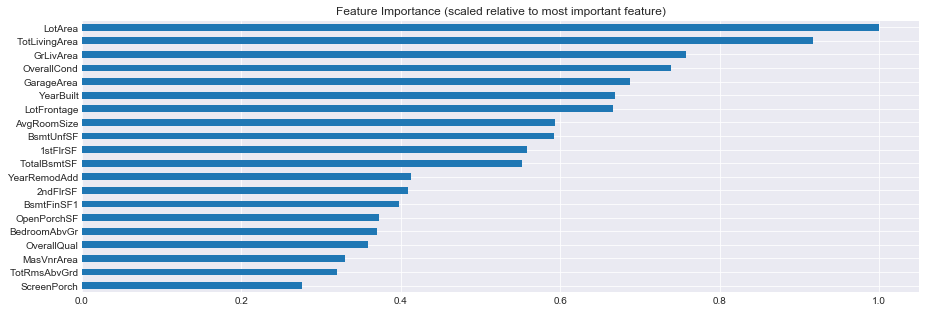

In [74]:
imp_ser.tail(20).plot.barh(figsize = (15,5))
plt.title('Feature Importance (scaled relative to most important feature)')
plt.show()

In [ ]:
averaged_models.fit(train_prep, y_train_log);

sub = pd.DataFrame()
sub['Id'] = all_data[train_count:]['Id']
sub['SalePrice'] = np.exp(averaged_models.predict(test_prep))
sub.to_csv('submission.csv',index=False)